In [10]:
from itertools import groupby
import numpy as np
import scipy.sparse as sp

from helpers import *
from plots import *

In [2]:
DATASET_PATH = 'data_train.csv'

In [3]:
ratings = load_data(DATASET_PATH)

number of items: 10000, number of users: 1000


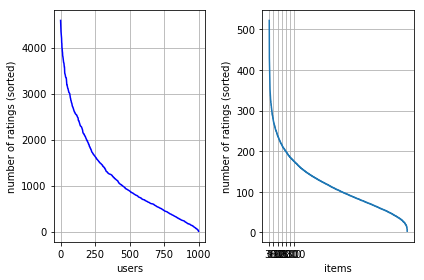

min # of movies per user = 8, min # of users per movie = 3.


In [4]:
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of movies per user = {}, min # of users per movie = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

In [9]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))

    nz_items, nz_users = valid_ratings.nonzero()
    
    # split the data
    for user in set(nz_users):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, user].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, user] = valid_ratings[residual, user]

        # add to test set
        test[selects, user] = valid_ratings[selects, user]

    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

the shape of original ratings. (# of row, # of col): (10000, 1000)
the shape of valid ratings. (# of row, # of col): (9990, 999)
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1065253
Total number of nonzero elements in test data:111620


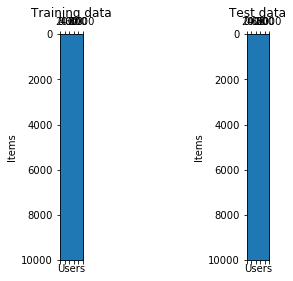

In [11]:
valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

#### Global Mean:

In [18]:
def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    # find the non zero ratings in the train
    nonzero_train = train[train.nonzero()]

    # calculate the global mean
    global_mean_train = nonzero_train.mean()

    # find the non zero ratings in the test
    nonzero_test = test[test.nonzero()].todense()

    # predict the ratings as global mean
    mse = calculate_mse(nonzero_test, global_mean_train)
    rmse = np.sqrt(1.0 * mse / nonzero_test.shape[1])
    print("test RMSE of baseline using the global mean: {v}.".format(v=rmse))
    
    return global_mean_train

pred = baseline_global_mean(train, test)
print(pred)

test RMSE of baseline using the global mean: [[ 1.12152228]].
3.85811070238


#### User Mean:

In [13]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape

    for user_index in range(num_users):
        # find the non-zero ratings for each user in the training dataset
        train_ratings = train[:, user_index]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            user_train_mean = nonzeros_train_ratings.mean()
        else:
            continue
        
        # find the non-zero ratings for each user in the test dataset
        test_ratings = test[:, user_index]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, user_train_mean)
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the user mean: {v}.".format(v=rmse))

baseline_user_mean(train, test)

test RMSE of the baseline using the user mean: [[ 1.03317038]].


#### Item Mean:

In [14]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    for item_index in range(num_items):
        # find the non-zero ratings for each item in the training dataset
        train_ratings = train[item_index, :]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]

        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            item_train_mean = nonzeros_train_ratings.mean()
        else:
            continue
        
        # find the non-zero ratings for each movie in the test dataset
        test_ratings = test[item_index, :]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, item_train_mean)
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the item mean: {v}.".format(v=rmse))
    
baseline_item_mean(train, test)

test RMSE of the baseline using the item mean: [[ 1.09633198]].
